In [1]:
import os
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

In [2]:
from model import AutoFormer
from datasets import CustomDataset
from utils.data import split_data, get_hour_features
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.train import train_step, val_step, test

In [3]:
# Global Constants
CSV_PATH = "data/traffic/traffic.csv"

TRAIN_PERC = .7
TEST_PERC = .1
BATCH_SIZE = 32

SEQ_LEN = 96 #Input Sequence Length
START_TOKEN_LEN = 48 #Start Token Length
PRED_LEN = 96 #Prediction sequence length
FEATURES = "M"

EPOCHS = 50
LR = .0001
LRADJ = "type1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Prepare Data

In [4]:
# Read Data
df = pd.read_csv(CSV_PATH)
df

,date,0,1,2,3,4,5,6,7,8,...,852,853,854,855,856,857,858,859,860,OT
0,2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2018-07-01 21:00:00,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,2018-07-01 22:00:00,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,2018-07-01 23:00:00,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,2018-07-02 00:00:00,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [5]:
# Carve out date index and features
dates = pd.to_datetime(df.iloc[:, 0])
data = df.iloc[:, 1:]

(train_data, train_dates), (val_data, val_dates), (test_data, test_dates) = split_data(data, dates, TRAIN_PERC, TEST_PERC)

train_time_feat = get_hour_features(train_dates)
val_time_feat = get_hour_features(val_dates)
test_time_feat = get_hour_features(test_dates)




In [6]:
print("train", train_data.shape, train_time_feat.shape)
train_dataset = CustomDataset(data=train_data,
                                   time_feat=train_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

print("validation", val_data.shape, val_time_feat.shape)
val_dataset = CustomDataset(data=val_data,
                                   time_feat=val_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)
print("test", test_data.shape, test_time_feat.shape)

test_dataset = CustomDataset(data=test_data,
                                   time_feat=test_time_feat,
                                   seq_len=SEQ_LEN,
                                   start_token_len=START_TOKEN_LEN,
                                   pred_len=PRED_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

train (12280, 862) (12280, 3)
validation (3510, 862) (3510, 3)
test (1754, 862) (1754, 3)


 ## Prepare Model

In [7]:
af_model = AutoFormer(enc_in=862, dec_in=862, c_out=862, factor=3)
opt = torch.optim.Adam(af_model.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

af_model.to(DEVICE)

AutoFormer(
  (decomp): SeriesDecomp(
    (moving_avg): MovingAvg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(862, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(862, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder):

## Train and Validate

In [8]:
#Train Step
run_name = f"run_{str(datetime.now().strftime('%s'))}"

path = os.path.join("./checkpoints/", run_name)
if not os.path.exists(path):
    os.makedirs(path)

train_steps = len(train_loader)
early_stopping = EarlyStopping(patience=3, verbose=True)

model_optim = optim.Adam(af_model.parameters(), lr=LR)
criterion = nn.MSELoss()

train_loss_list = []
val_loss_list = []
for epoch in range(EPOCHS):
    train_loss = train_step(af_model, train_loader, model_optim, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)
    val_loss = val_step(af_model, val_loader, criterion, DEVICE, PRED_LEN, START_TOKEN_LEN)

    early_stopping(val_loss, af_model, path)
    if early_stopping.early_stop:
        print("Early Stopping")
        break
    
    adjust_learning_rate(model_optim, epoch+1, adjust_type="type1", lr=LR)
    
    print(epoch, train_loss, val_loss)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)



Validation loss decreased (inf --> 0.399050).  Saving model ...
Updating learning rate to 0.0001
0 0.47158796346155973 0.39905033
Validation loss decreased (0.399050 --> 0.372986).  Saving model ...
Updating learning rate to 5e-05
1 0.35556685841526214 0.37298647
Validation loss decreased (0.372986 --> 0.324259).  Saving model ...
Updating learning rate to 2.5e-05
2 0.3118316487703146 0.32425907
Validation loss decreased (0.324259 --> 0.308042).  Saving model ...
Updating learning rate to 1.25e-05
3 0.2907838797695757 0.30804172
Validation loss decreased (0.308042 --> 0.296802).  Saving model ...
Updating learning rate to 6.25e-06
4 0.28169570412654776 0.29680207
Validation loss decreased (0.296802 --> 0.288709).  Saving model ...
Updating learning rate to 3.125e-06
5 0.27765518909107784 0.2887087
Validation loss decreased (0.288709 --> 0.284338).  Saving model ...
Updating learning rate to 1.5625e-06
6 0.274973735924741 0.28433815
Validation loss decreased (0.284338 --> 0.282916).  Sa

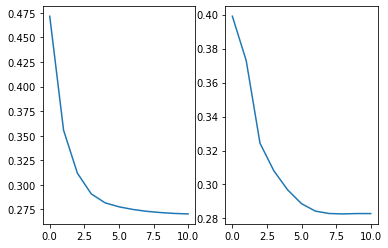

In [9]:
f, axarr = plt.subplots(1, 2)

x_index = [i for i in range(len(train_loss_list))]

axarr[0].plot(x_index, train_loss_list)
axarr[1].plot(x_index, val_loss_list)

## Test and visualize predicitons

In [10]:
input, pred, true = test(af_model, test_loader, run_name, DEVICE, PRED_LEN, START_TOKEN_LEN)
print(input.shape, pred.shape, true.shape)

test shape: (48, 32, 96, 862) (48, 32, 96, 862)
test shape: (1536, 96, 862) (1536, 96, 862)


/scratch/ssd002/home/jewtay/transformer_forecasting/utils/metrics.py:27: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((pred - true) / true))
/scratch/ssd002/home/jewtay/transformer_forecasting/utils/metrics.py:31: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.square((pred - true) / true))


mse:0.3418215215206146, mae:0.339632123708725
(1536, 96, 862) (1536, 96, 862) (1536, 96, 862)


In [11]:
ss_indices = np.random.choice(range(pred.shape[0]), 2, replace=False)
ss_pred = pred[ss_indices]
ss_true = true[ss_indices]
ss_input = input[ss_indices]

col_indices = list(np.random.choice(range(ss_pred.shape[2]), 10, replace=False))
print(len(col_indices), ss_pred.shape, ss_true.shape, ss_input.shape)

10 (2, 96, 862) (2, 96, 862) (2, 96, 862)


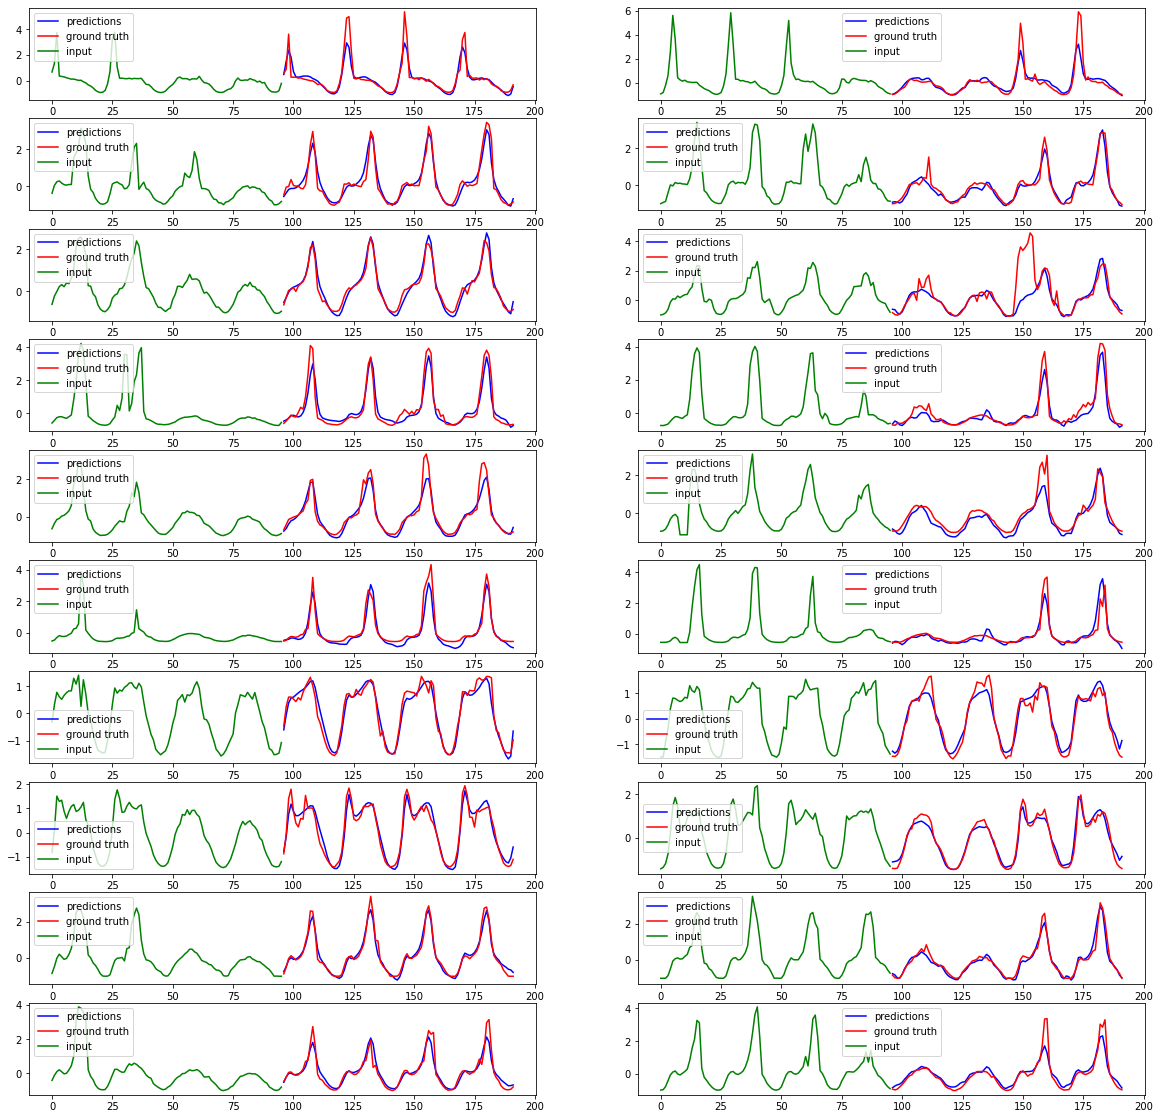

In [12]:
f, axarr = plt.subplots(len(col_indices), ss_pred.shape[0], figsize=(20, 20))
for fig_x, i in enumerate(col_indices):
    series_preds = ss_pred[:, :, i].squeeze()
    series_trues = ss_true[:, :, i].squeeze()
    series_inputs = ss_input[:, :, i].squeeze()
    for j in range(ss_pred.shape[0]):
        series_pred = series_preds[j, :].squeeze()
        series_true = series_trues[j, :].squeeze()
        series_input = series_inputs[j, :].squeeze()
        input_len = series_input.shape[0]
        pred_gt_len = series_pred.shape[0]
        input_x = np.array([i for i in range(input_len)])
        x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
        axarr[fig_x, j].plot(x, series_pred, c="blue", label="predictions")
        axarr[fig_x, j].plot(x, series_true, c="red", label="ground truth")
        axarr[fig_x, j].plot(input_x, series_input, c="green", label="input")
        axarr[fig_x, j].legend()
